# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS);path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [8]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c: Union[pathlib.Path, str], check_ext: bool = True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_15.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Sphynx_186.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_160.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/japanese_chin_20.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/samoyed_86.jpg')]

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

L'istruzione sotto ritorna un oggetto DataBunch che contiene 3 data set generalmente: 
- dati di allenamento (training data)
- dati di validazione
- dati di test (opzionali)

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

* **path_img**: a path containing images
* **fnames**: a list of file names
* **pat**: a regular expression (i.e. pattern) to be used to extract the label from the file name
* **ds_tfm**: we'll talk about transforms later
* **size**: what size images do you want to work with.
* **bs**: batch size (i.e. number of images processed at a time). Set to 16 if memory is not enough.

This might seem weird because images have size. This is a shortcoming of current deep learning technology which is that a GPU has to apply the exact same instruction to a whole bunch of things at the same time in order to be fast. If the images are different shapes and sizes, you can't do that. So we actually have to make all of the images the same shape and size. In part 1 of the course, we are always going to be making images square shapes. Part 2, we will learn how to use rectangles as well. It turns out to be surprisingly nuanced. But pretty much everybody in pretty much all computer vision modeling nearly all of it uses this approach of square. 224 by 224, for reasons we'll learn about, is an extremely common size that most models tend to use so if you just use size=224, you're probably going to get pretty good results most of the time. This is kind of the little bits of artisanship that I want to teach you which is what generally just works. So if you just use size 224, that'll generally just work for most things most of the time.

**Normalizing the images** means that the pixel values start out from naught to 255. And some channels might tend to be really bright, some might tend to be really not bright at all, some might vary a lot, and some might not very much at all. It really helps train a deep learning model if each one of those red green and blue channels has a mean of zero and a standard deviation of one.


If your data is not normalized, it can be quite difficult for your model to train well. So if you have trouble training a model, one thing to check is that you've normalized it.

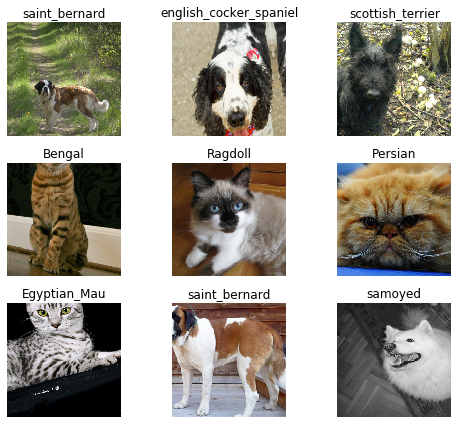

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

For now, the most important thing for you to know is that there's a particular kind of model called ResNet which works extremely well nearly all the time. For a while, at least, you really only need to be doing choosing between two things which is what size ResNet do you want. There are ResNet34 and ResNet50. When we are getting started with something, I'll pick a smaller one because it'll train faster. That's as much as you need to know to be a pretty good practitioner about architecture for now which is that there are two variants of one architecture that work pretty well: ResNet34 and ResNet50. Start with a smaller one and see if it's good enough.

In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.381723,0.297590,0.100135,00:39
1,0.637532,0.246451,0.083221,00:32
2,0.392323,0.216655,0.072395,00:32
3,0.273915,0.204057,0.066982,00:32


* **Training loss** is the error on the training set of data.
* **Validation loss** is the error after running the validation set of data through the trained network.
* **Error rate** is the percentage of errors in our model. For the epoch 3 we fail 6% of times, we are right 94%

The way to do that is using something called a validation set. A validation set is a set of images that your model does not get to look at. So these metrics (e.g. error_rate) get printed out automatically using the validation set - a set of images that our model never got to see. When we created our data bunch, it automatically created a validation set for us. We'll learn lots of ways of creating and using validation sets, but because we're trying to bake in all of the best practices, we actually make it nearly impossible for you not to use a validation set. Because if you're not using a validation set, you don't know if you're overfitting. So we always print out the metrics on a validation, we've always hold it out, we always make sure that the model doesn't touch it. That's all done for you, and all built into this data bunch object.

If *validation loss >> training loss* you can call it **overfitting**. We are doing much better (too much?) than the normal behaviour

If *validation loss << training loss* you can call it **underfitting**. We are doing worse!

4, basically decides how many times do we go through the entire dataset, how many times do we show the dataset to the model so that it can learn from it. Each time it sees a picture, it's going to get a little bit better. But it's going to take time and it means it could overfit. If it sees the same picture too many times, it will just learn to recognize that picture, not pets in general. We'll learn all about how to tune this number during the next couple of lessons but starting out with 4 is a pretty good start just to see how it goes and you can actually see after four epochs or four cycles, we got an error rate of 6%. And it took 1 minute and 56 seconds.

In [19]:
learn.save('stage-1')

The first time I run this on a newly installed box, it downloads the **ResNet34** pre-trained weights. What that means is that this particular model has actually already been trained for a particular task. And that particular task is that it was trained on looking at about one and a half million pictures of all kinds of different things, a thousand categories of things, using an image dataset called ImageNet. So we can download those pre-trained weights so that we don't start with a model that knows nothing about anything, but we actually start with a model that knows how to recognize a thousand categories of things in ImageNet. I don't think all of these 37 categories of pet are in ImageNet but there were certainly some kinds of dog and some kinds of cat. So this pre-trained model knows quite a little bit about what pets look like, and it certainly knows quite a lot about what animals look like and what photos look like. So the idea is that we don't start with a model that knows nothing at all, but we start by downloading a model that knows something about recognizing images already. So it downloads for us automatically, the first time we use it, a pre-trained model and then from now on, it won't need to download it again - it'll just use the one we've got.

## Results

[Extended notes](https://github.com/hiromis/notes/blob/master/Lesson1.md#results-10854)

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

**loss function** is something that tells you how good was your prediction. Specifically that means if you predicted one class of cat with great confidence, but actually you were wrong, then that's going to have a high loss because you were very confident about the wrong answer. So that's what it basically means to have high loss. By plotting the top losses, we are going to find out what were the things that we were the most wrong on, or the most confident about what we got wrong.

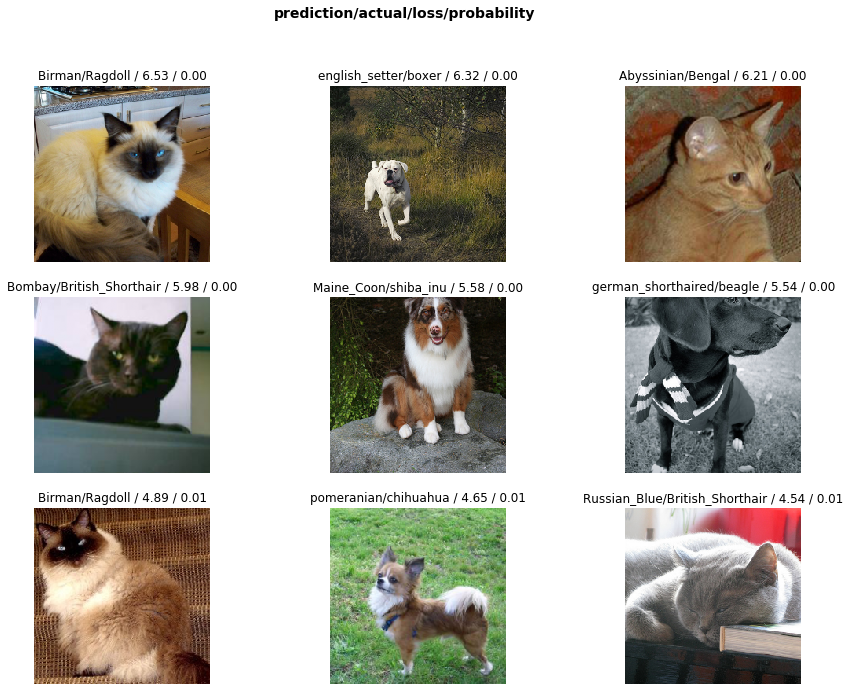

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

The title of each image shows: prediction, actual, loss, probability of actual class.

Another useful tool, kind of, is to use something called a **confusion matrix** which basically shows you for every actual type of dog or cat, how many times was it predicted to be that dog or cat. But unfortunately, in this case, because it's so accurate, this diagonal basically says how it's pretty much right all the time. 

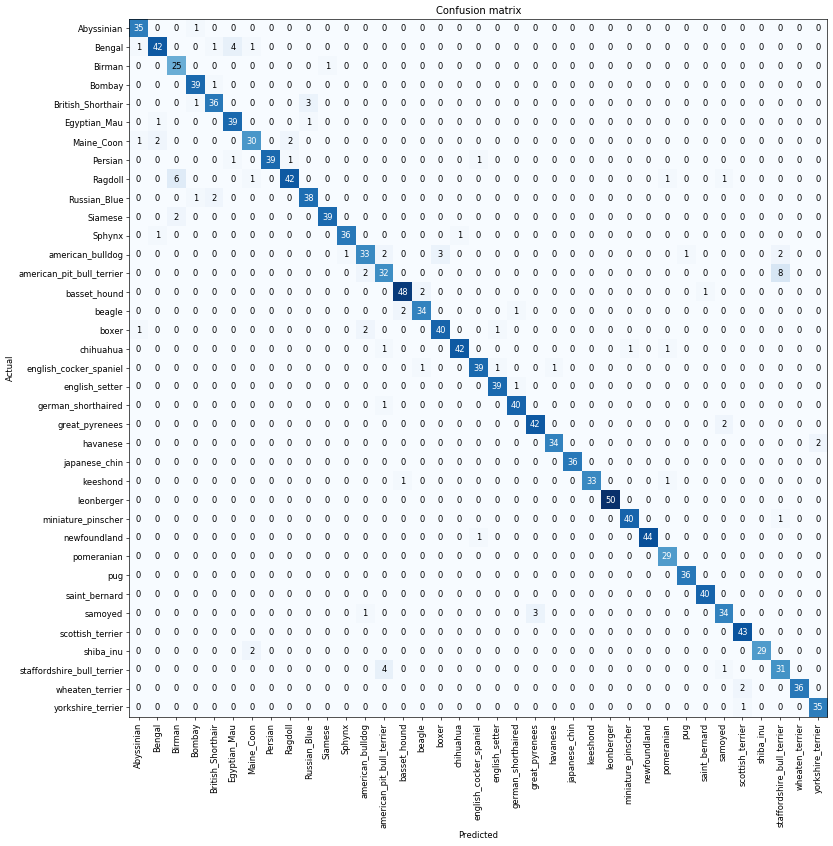

In [24]:
interp.plot_confusion_matrix(figsize=(14,14), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Ragdoll', 'Birman', 6),
 ('Bengal', 'Egyptian_Mau', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('american_bulldog', 'boxer', 3),
 ('samoyed', 'great_pyrenees', 3),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('basset_hound', 'beagle', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_bulldog', 2),
 ('great_pyrenees', 'samoyed', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('shiba_inu', 'Maine_Coon', 2),
 ('wheaten_terrier', 'scottish_terrier', 2)]

## Unfreezing, fine-tuning, and learning rates - TODO

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.558166,0.314579,0.101489


In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


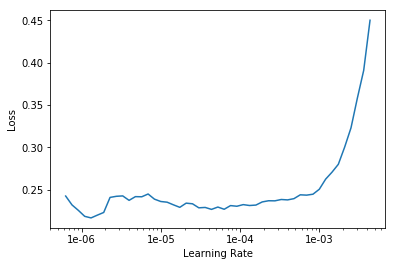

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.242544,0.208489,0.067659
2,0.206940,0.204482,0.062246


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


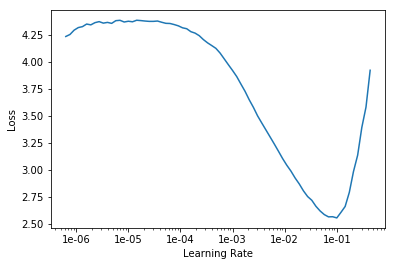

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

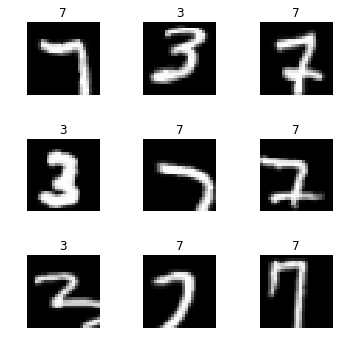

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

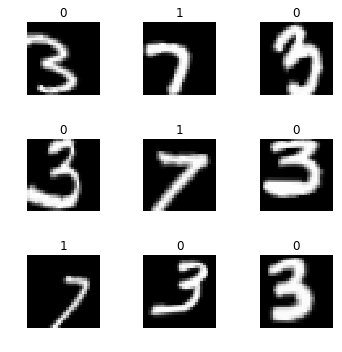

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']